In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
#from __future__ import print_function

All the datasets used in this text are available online at
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [43]:
colors = ["#348ABD", "#A60628"]

In [44]:
prior = [1/21., 20/21.]

In [45]:
import scipy.stats as stats

In [46]:
a = np.arange(100)

In [47]:
poi = stats.poisson

In [48]:
duh = poi.pmf(a, 50)

In [49]:
duhseries = pd.Series(duh, index=a)

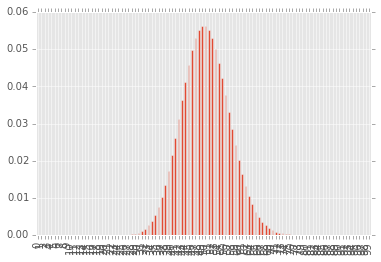

In [50]:
duhseries.plot(kind='bar')

In [51]:
a = np.linspace(0,4,300)
expo = stats.expon

In [52]:
supduh = expo.pdf(a, scale=1/4.)

In [53]:
dumsupduh = pd.Series(supduh, index=a)

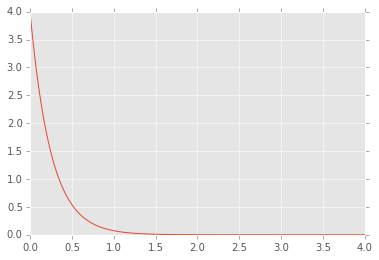

In [54]:
dumsupduh.plot()

In [55]:
count_data = np.loadtxt("data/txtdata.csv")

In [56]:
count_data

array([ 13.,  24.,   8.,  24.,   7.,  35.,  14.,  11.,  15.,  11.,  22.,
        22.,  11.,  57.,  11.,  19.,  29.,   6.,  19.,  12.,  22.,  12.,
        18.,  72.,  32.,   9.,   7.,  13.,  19.,  23.,  27.,  20.,   6.,
        17.,  13.,  10.,  14.,   6.,  16.,  15.,   7.,   2.,  15.,  15.,
        19.,  70.,  49.,   7.,  53.,  22.,  21.,  31.,  19.,  11.,  18.,
        20.,  12.,  35.,  17.,  23.,  17.,   4.,   2.,  31.,  30.,  13.,
        27.,   0.,  39.,  37.,   5.,  14.,  13.,  22.])

In [57]:
countdataseries = pd.Series(count_data)

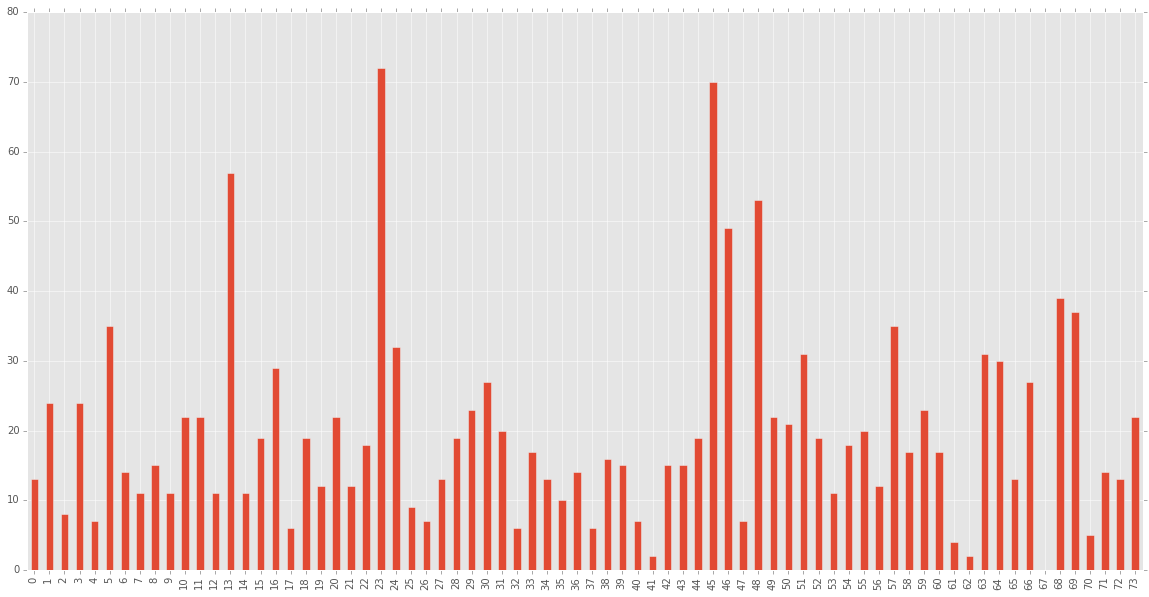

In [58]:
countdataseries.plot(kind='bar',figsize=(20,10))

In [59]:
import pymc as pm
n_count_data = len(count_data)

In [60]:
alpha = 1.0/count_data.mean()  # Recall that count_data is the 
                               # variable that holds our text counts. 
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=len(count_data))

In [61]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data) # number of data points 
    out[:tau] = lambda_1  # lambda before tau is lambda_1 
    out[tau:] = lambda_2  # lambda after (and including) tau is 
                          # lambda_2 
    return out

In [62]:
observation = pm.Poisson("obs", lambda_, value=count_data,
                         observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [63]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 3.8 sec

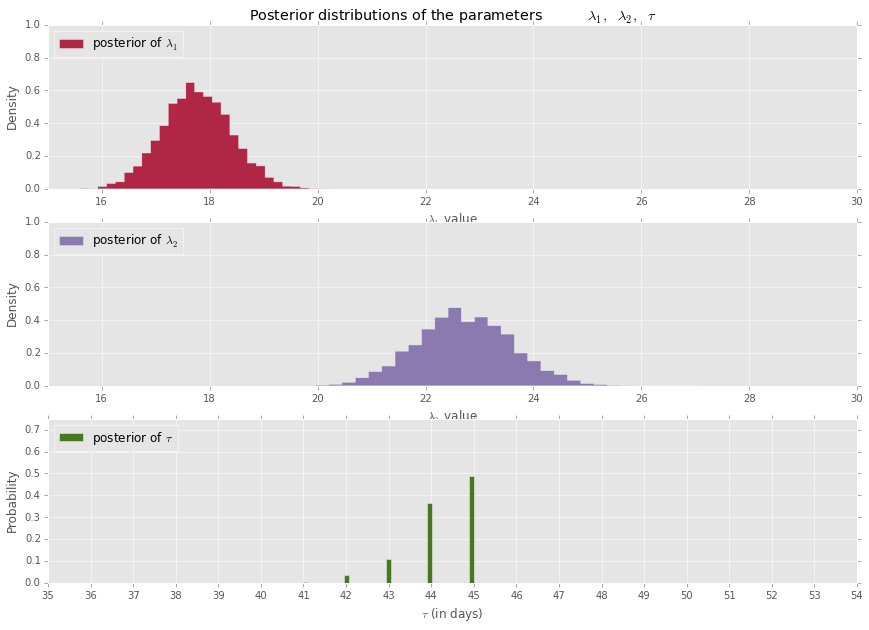

In [64]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

fig = plt.figure(figsize=(14.5,10))

#figsize(14.5, 10)
# histogram of the samples 

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the parameters\
          $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$", color="#467821",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("Probability");

In [83]:
import pymc as pm

p = pm.Uniform('p', lower=0, upper = 1)

In [85]:
# set constants 
p_true = 0.05 # remember, this is unknown in real-life 
N = 55000

# Sample N Bernoulli random variables from Ber(0.05). 
# Each random variable has a 0.05 chance of being a 1. 
# This is the data-generation step. 
occurrences = pm.rbernoulli(p_true, N)

print(occurrences) # Remember: Python treats True == 1, and False == 0. 
print(occurrences.sum())

[False False False ..., False False False]
2750


In [86]:
# Occurrences.mean() is equal to n/N. 
print("What is the observed frequency in Group A? %.4f " % occurrences.mean())
print("Does the observed frequency equal the true frequency? %s "  % (occurrences.mean() == p_true))

What is the observed frequency in Group A? 0.0500 
Does the observed frequency equal the true frequency? True 


In [87]:
# Include the observations, which are Bernoulli. 
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# to be explained in Chapter 3 
mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)



 [-----------------100%-----------------] 20000 of 20000 complete in 9.2 sec

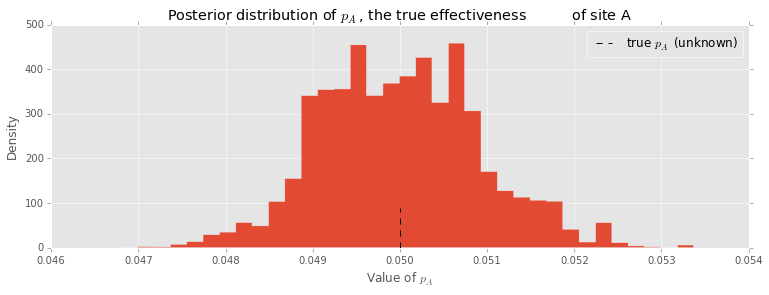

In [88]:
fig = plt.figure(figsize=(12.5,4))
plt.title("Posterior distribution of $p_A$, the true effectiveness\
          of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=35, histtype="stepfilled",
         normed=True)
plt.xlabel("Value of $p_A$")
plt.ylabel("Density")
plt.legend();